# Install & Import needed libraries

In [2]:
!pip install datasets transformers sentencepiece accelerate evaluate rouge-score nltk -q
!pip install fsspec==2023.6.0 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 85.1 MB/s eta 0:00:00
  Using cached fsspec-2023.6.0-py3-none-any.whl.metadata (6.7 kB)
Using cached fsspec-2023.6.0-py3-none-any.whl (163 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.


In [85]:
import torch
import pandas as pd
import numpy as np
import random
import nltk
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load DATASET

In [4]:
print("Loading RAG-Instruct dataset...")
dataset = load_dataset("FreedomIntelligence/RAG-Instruct", split="train")

print(f"Loaded {len(dataset)} QA pairs.")

Loading RAG-Instruct dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

rag_instruct.json:   0%|          | 0.00/296M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40541 [00:00<?, ? examples/s]

Loaded 40541 QA pairs.


# Prepare sample data

In [89]:
nltk.download('punkt')
nltk.download('punkt_tab')

# Set random seed fixed for reproducibility
RANDOM_SEED = 33
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [90]:
sample_size = 100
eval_sample_size = 10
#dataset_sample = dataset.shuffle(seed=RANDOM_SEED).select(range(sample_size)) #fixed
dataset_sample = dataset.shuffle().select(range(sample_size)) # always different sample

if not isinstance(dataset_sample, list):
    dataset_sample = [dict(item) for item in dataset_sample]

In [91]:
print("Example from shuffled dataset:")
print("Q:", dataset_sample[0]['question'])
print("First doc:", dataset_sample[0]['documents'][0][:150], "...")
print("Answer:", dataset_sample[0]['answer'])

Example from shuffled dataset:
Q: Pick the right choice from the options provided below:

What is a common consequence of the triboelectric effect when a plastic comb passes through hair?
A. The comb becomes magnetically charged.
B. The comb and hair remain electrically neutral.
C. The comb becomes electrically charged due to the friction with the hair.
D. The comb and hair experience a permanent chemical change.
First doc: high electric field near the points of the nearby comb (2). At the points, the field becomes strong enough to ionize air molecules, and the electrons  ...
Answer: C. The comb becomes electrically charged due to the friction with the hair. The triboelectric effect is responsible for charging objects through frictional contact with different materials. When a plastic comb is passed through hair, the triboelectric effect occurs, leading to the accumulation of static electricity on the comb. This occurs because different materials exchange electrons due to the contact a

# Load LLM
> model: google/flan-t5-base



In [9]:
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Get Answer from model

In [94]:
def generate_answer(prompt, max_new_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens) #use the model
    return tokenizer.decode(outputs[0], skip_special_tokens=True) # skip: Don't show tokens like <pad>, <eos>, etc.

# Compute Scores


>1. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
Used for: summarization, QA, generation

It checks:

How much of the reference text (true answer) is captured in the predicted text

Measures overlap of words, phrases, or sequences.

ROUGE-1: Unigram (1-word) overlap.

ROUGE-L: Longest common subsequence

>2. BLEU (Bilingual Evaluation Understudy)
Used originally for machine translation

Measures precision of predicted words vs reference

Scores closer to 1.0 = more overlap

`BLEU is stricter than ROUGE and often gives lower scores.`

In [104]:
def compute_metrics(predictions, references):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1, rougel, bleu_scores = 0, 0, []
    smooth_fn = SmoothingFunction().method1

    for pred, ref in zip(predictions, references):
        scores = rouge.score(pred, ref)
        rouge1 += scores['rouge1'].fmeasure
        rougel += scores['rougeL'].fmeasure
        pred_tokens = nltk.word_tokenize(pred.lower())
        ref_tokens = nltk.word_tokenize(ref.lower())
        try:
            bleu = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
        except:
            bleu = 0
        bleu_scores.append(bleu)

    n = len(predictions)
    return {
        "rouge1": rouge1 / n,
        "rougeL": rougel / n,
        "bleu": sum(bleu_scores) / n
    }

```
BLEU compares n-gram overlaps between your model’s answer (hypothesis) and the true answer (reference).

If the predicted answer is very short or unrelated, it has no 2-gram or 3-gram overlaps, causing BLEU to drop to zero.
```

# Dynamically format prompt for all methods & Add prewritten ones

In [109]:
def format_prompt(template, question, documents, example=None, fewshot_examples=None):
    doc_text = "\n\n".join(documents[:1])
    prompt = template.format(
        context=doc_text,
        question=question,
        docs=doc_text,
        answer=example['answer'] if example else "",
        example_question=example['question'] if example else "",
        example_context="\n\n".join(example['documents'][:1]) if example else ""
    )
    if fewshot_examples:
        fewshot_str = ""
        for ex in fewshot_examples:
            fewshot_str += f"Documents:\n{ex['documents'][0][:250]}\nQ: {ex['question']}\nA: {ex['answer']}\n\n"
        prompt = fewshot_str + prompt
    return prompt

In [108]:
zero_shot_prompts = [
    "Answer the following question Q: {question}\nbased only on this context:\n{context}...\nA:",
    "Can you look at the following document and answer this question?\nDocument: {docs}\nQuestion: {question}\nA:",
    "Using the information below, answer concisely.\n{context}\nQ: {question}\nA:"
]

one_shot_prompts = [
    "From the given example:\n{example_context}\nQ: {example_question}\nA: {answer}\n\nCan you answer this:\n{context}\nQ: {question}\nA:",
    "Here is a solved example:\nContext: {example_context}\nQ: {example_question}\nA: {answer}\n\nAnswer this:\n{context}\nQ: {question}\nA:",
    "Use the structure below to answer a similar question.\nPassage: {context}\nQ: {question}\nA:"
]

few_shot_prompts = [
    "{context}\nQ: {question}\nA:",
    "Refer to the examples and then answer:\n{context}\nQ: {question}\nA:",
    "Answer after seeing the examples above:\n{context}\nQ: {question}\nA:"
]

# Dynamically evaluate shots

In [111]:
def evaluate(prompt_template, mode='zero'):
    preds, refs = [], []
    few_examples = dataset_sample[:3]  # Used for few-shot prompting
    example = dataset_sample[0]        # Used for one-shot prompting

    for item in tqdm(dataset_sample[:eval_sample_size]):
        prompt = format_prompt(
            template=prompt_template,
            question=item['question'],
            documents=item['documents'],
            example=example if mode == 'one' else None,
            fewshot_examples=few_examples if mode == 'few' else None
        )
        #print("\n🔍 Prompt Preview:\n", prompt[:300])
        pred = generate_answer(prompt)
        #print("✅ Answer generated: ", pred)
        preds.append(pred)
        refs.append(item['answer'])

    return compute_metrics(preds, refs)

# Test

In [106]:
result = {}

print("Running Zero shot...")
result['zero-shot'] = evaluate(zero_shot_prompts[0], mode='zero')

Running Zero shot...


  0%|          | 0/10 [00:00<?, ?it/s]


🔍 Prompt Preview:
 Answer the following question Q: Pick the right choice from the options provided below:

What is a common consequence of the triboelectric effect when a plastic comb passes through hair?
A. The comb becomes magnetically charged.
B. The comb and hair remain electrically neutral.
C. The comb becomes e
✅ Answer generated:  B.

🔍 Prompt Preview:
 Answer the following question Q: Answer the following question by selecting one of the options:

In the depictions and references to Veronica in Christian traditions and adaptations, what common symbol does she offer to Jesus?
A. a crown of thorns
B. a linen cloth
C. a wooden cross
D. a glass of wat
✅ Answer generated:  B

🔍 Prompt Preview:
 Answer the following question Q: In 2020, what currency designs were planned to be unveiled to coincide with what significant women's rights anniversary?
based only on this context:
was confident that "this act—and the new dollar—will substantially improve our coinage system as well as cutt

In [107]:
print("Running One shot...")
result['one-shot'] = evaluate(one_shot_prompts[0], mode='one')

Running One shot...


  0%|          | 0/10 [00:00<?, ?it/s]


🔍 Prompt Preview:
 From the given example:
high electric field near the points of the nearby comb (2). At the points, the field becomes strong enough to ionize air molecules, and the electrons are attracted to the outside of the belt while positive ions go to the comb. At the comb (2) they are neutralized by electrons
✅ Answer generated:  C.

🔍 Prompt Preview:
 From the given example:
high electric field near the points of the nearby comb (2). At the points, the field becomes strong enough to ionize air molecules, and the electrons are attracted to the outside of the belt while positive ions go to the comb. At the comb (2) they are neutralized by electrons
✅ Answer generated:  B.

🔍 Prompt Preview:
 From the given example:
high electric field near the points of the nearby comb (2). At the points, the field becomes strong enough to ionize air molecules, and the electrons are attracted to the outside of the belt while positive ions go to the comb. At the comb (2) they are neutralized by

In [110]:
print("Running Few shot...")
result['few-shot'] = evaluate(few_shot_prompts[0], mode='few')

Running Few shot...


  0%|          | 0/10 [00:00<?, ?it/s]


🔍 Prompt Preview:
 Documents:
high electric field near the points of the nearby comb (2). At the points, the field becomes strong enough to ionize air molecules, and the electrons are attracted to the outside of the belt while positive ions go to the comb. At the comb (2) they ar
Q: Pick the right choice from the opti
✅ Answer generated:  C.

🔍 Prompt Preview:
 Documents:
high electric field near the points of the nearby comb (2). At the points, the field becomes strong enough to ionize air molecules, and the electrons are attracted to the outside of the belt while positive ions go to the comb. At the comb (2) they ar
Q: Pick the right choice from the opti
✅ Answer generated:  B.

🔍 Prompt Preview:
 Documents:
high electric field near the points of the nearby comb (2). At the points, the field becomes strong enough to ionize air molecules, and the electrons are attracted to the outside of the belt while positive ions go to the comb. At the comb (2) they ar
Q: Pick the right choice fro

# Plot results

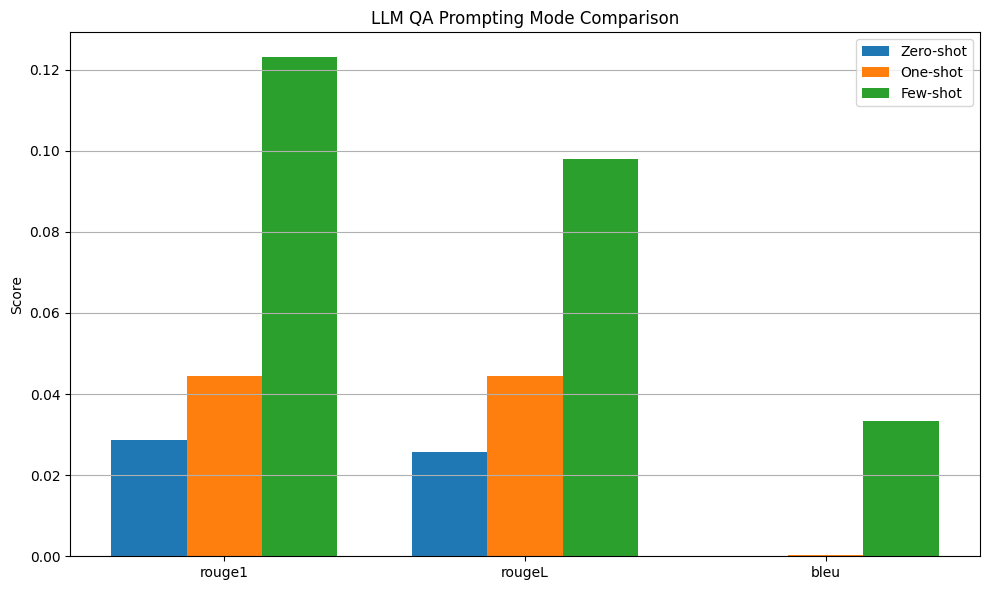

In [112]:
labels = list(result['zero-shot'].keys())
zero = [result['zero-shot'][m] for m in labels]
one = [result['one-shot'][m] for m in labels]
few = [result['few-shot'][m] for m in labels]

x = np.arange(len(labels))
bar_width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x, zero, width=bar_width, label='Zero-shot')
plt.bar(x + bar_width, one, width=bar_width, label='One-shot')
plt.bar(x + 2 * bar_width, few, width=bar_width, label='Few-shot')

plt.xticks(x + bar_width, labels)
plt.ylabel('Score')
plt.title('LLM QA Prompting Mode Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Result Scores

In [113]:
print("\n📊 Final Evaluation Scores:")
for mode, score in result.items():
    print(f"\n{mode.upper()}:")
    for metric, val in score.items():
        print(f"  {metric}: {val:.4f}")


📊 Final Evaluation Scores:

ZERO-SHOT:
  rouge1: 0.0286
  rougeL: 0.0257
  bleu: 0.0000

ONE-SHOT:
  rouge1: 0.0444
  rougeL: 0.0444
  bleu: 0.0003

FEW-SHOT:
  rouge1: 0.1230
  rougeL: 0.0980
  bleu: 0.0334
